In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gensim.models import KeyedVectors
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

import sys
from pathlib import Path

# Add the project root directory to Python path
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import load_models

import matplotlib.pyplot as plt
# 设置更好的可视化风格

# 设置更好的可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
# 假设notebooks目录在项目根目录下


from src.utils import download_chinese_font
import src.utils as utils
# 下载并安装字体
font_path = download_chinese_font()

# 设置matplotlib使用下载的字体
if font_path:
    plt.rcParams['font.sans-serif'] = ['SimHei'] + plt.rcParams['font.sans-serif']
    print("成功设置中文字体")
else:
    print("无法设置中文字体，将使用替代方案")

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


# 定义项目根目录和模型目录
PROJECT_ROOT = Path.cwd().parent
MODELS_DIR = PROJECT_ROOT / "models"



字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体


In [2]:
from clustering_analysis import ClusteringAnalyzer
    # 1. 初始化
try:
    models = utils.load_models(MODELS_DIR)
    output_dir = PROJECT_ROOT / "output" / "clustering_analysis"
    analyzer = ClusteringAnalyzer(models, output_dir)
except (ValueError, FileNotFoundError) as e:
    print(f"初始化分析器失败: {e}")



字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体
字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体
使用固定时期模型目录: /home/fangshikai/law-word-vector/models/fine_tuned_vectors_flexible
找到 3 个模型文件:
  加载模型: Era1_1978-1996
  成功加载 Era1_1978-1996, 词汇量: 4874
  加载模型: Era2_1997-2013
  成功加载 Era2_1997-2013, 词汇量: 4992
  加载模型: Era3_2014-2024
  成功加载 Era3_2014-2024, 词汇量: 5000

DimensionAnalyzer 初始化成功，共加载 3 个模型。
ClusteringAnalyzer 初始化成功，输出目录: /home/fangshikai/law-word-vector/output/clustering_analysis


加载 Era1_1978-1996: 150 个词
加载 Era2_1997-2013: 150 个词
加载 Era3_2014-2024: 150 个词
已加载 17 个排除词
Era1_1978-1996: 过滤后保留 149 个词
Era2_1997-2013: 过滤后保留 148 个词
Era3_2014-2024: 过滤后保留 148 个词
所有时期共有词: 41 个
所有时期词汇并集: 284 个

--- 开始对 284 个词进行 3-聚类 ---
使用 Era3_2014-2024 模型进行聚类
聚类1: 47 个词, 前10个: ['法律宣传', '法律意识', '违法不究', '人人平等', '行使权力', '社会公德', '徒法', '法律化', '执法者', '司法腐败']
聚类2: 96 个词, 前10个: ['产权保护', '律师', '贯彻实施', '法制宣传', '安全法', '营商', '纪律', '涉外', '执法', '地方性']
聚类3: 90 个词, 前10个: ['人民意志', '化解矛盾', '市场经济', '民族事务', '严明', '法理', '理论指导', '德治', '国家治理', '依法治国']


已保存聚类结果到: /home/fangshikai/law-word-vector/output/clustering_analysis/cluster_results_3d.png


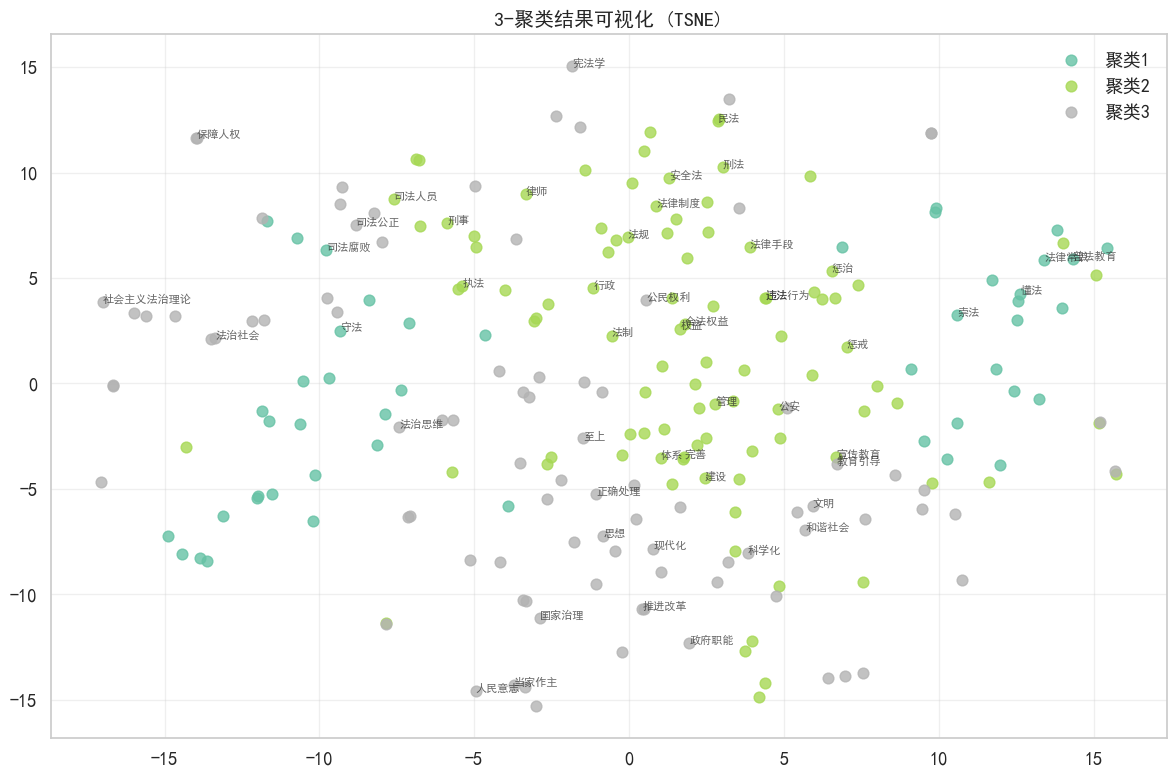

已保存聚类结果到: /home/fangshikai/law-word-vector/output/clustering_analysis/cluster_results_3d.txt
轮廓系数 (Silhouette Score): 0.041
Calinski-Harabasz 指数: 11.753
已加载 17 个排除词
Era1_1978-1996: 过滤后保留 149 个词
Era2_1997-2013: 过滤后保留 148 个词
Era3_2014-2024: 过滤后保留 148 个词
所有时期共有词: 41 个
所有时期词汇并集: 284 个

--- 开始对 284 个词进行 4-聚类 ---
使用 Era3_2014-2024 模型进行聚类
聚类1: 45 个词, 前10个: ['法律宣传', '法律意识', '违法不究', '法制宣传', '人人平等', '行使权力', '社会公德', '徒法', '执法者', '司法腐败']
聚类2: 65 个词, 前10个: ['律师', '贯彻实施', '法理', '安全法', '涉外', '执法', '地方性', '刑事', '监督机制', '依法']
聚类3: 91 个词, 前10个: ['化解矛盾', '市场经济', '产权保护', '民族事务', '严明', '营商', '纪律', '理论指导', '德治', '建立健全']
聚类4: 32 个词, 前10个: ['人民意志', '国家治理', '依法治国', '当家作主', '法律化', '善治', '法典', '保障人权', '社会主义法治理论', '法治政府']
已保存聚类结果到: /home/fangshikai/law-word-vector/output/clustering_analysis/cluster_results_4d.png


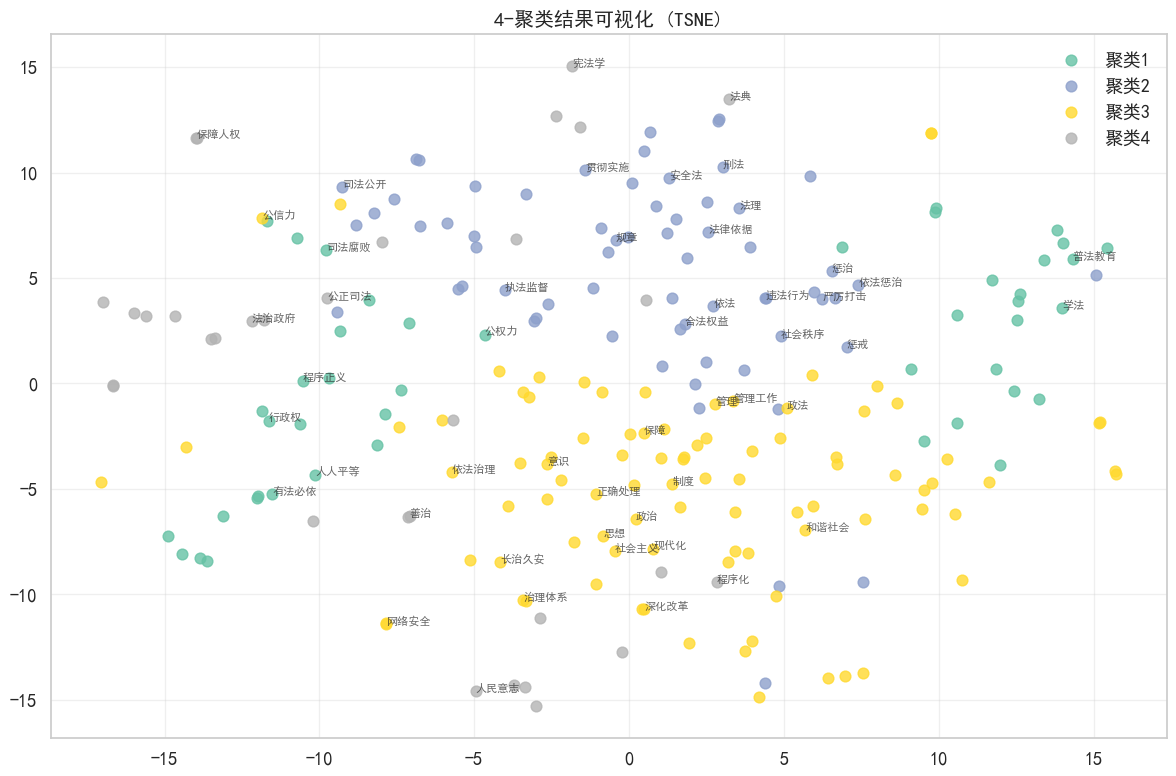

已保存聚类结果到: /home/fangshikai/law-word-vector/output/clustering_analysis/cluster_results_4d.txt
轮廓系数 (Silhouette Score): 0.038
Calinski-Harabasz 指数: 10.873
已加载 17 个排除词
Era1_1978-1996: 过滤后保留 149 个词
Era2_1997-2013: 过滤后保留 148 个词
Era3_2014-2024: 过滤后保留 148 个词
所有时期共有词: 41 个
所有时期词汇并集: 284 个

--- 开始对 284 个词进行 5-聚类 ---
使用 Era3_2014-2024 模型进行聚类
聚类1: 15 个词, 前10个: ['严明', '人人平等', '纪律', '行使权力', '廉洁', '廉政', '司法腐败', '遵纪守法', '法纪', '惩恶扬善']
聚类2: 70 个词, 前10个: ['产权保护', '律师', '贯彻实施', '安全法', '执法', '地方性', '建立健全', '刑事', '保障体系', '健全']
聚类3: 79 个词, 前10个: ['化解矛盾', '市场经济', '民族事务', '营商', '涉外', '理论指导', '德治', '国家治理', '体系', '和谐']
聚类4: 34 个词, 前10个: ['人民意志', '法理', '依法治国', '当家作主', '法律化', '善治', '立法法', '法典', '保障人权', '社会主义法治理论']
聚类5: 35 个词, 前10个: ['法律宣传', '法律意识', '违法不究', '法制宣传', '社会公德', '徒法', '执法者', '崇法', '以言代法', '司法权威']
已保存聚类结果到: /home/fangshikai/law-word-vector/output/clustering_analysis/cluster_results_5d.png


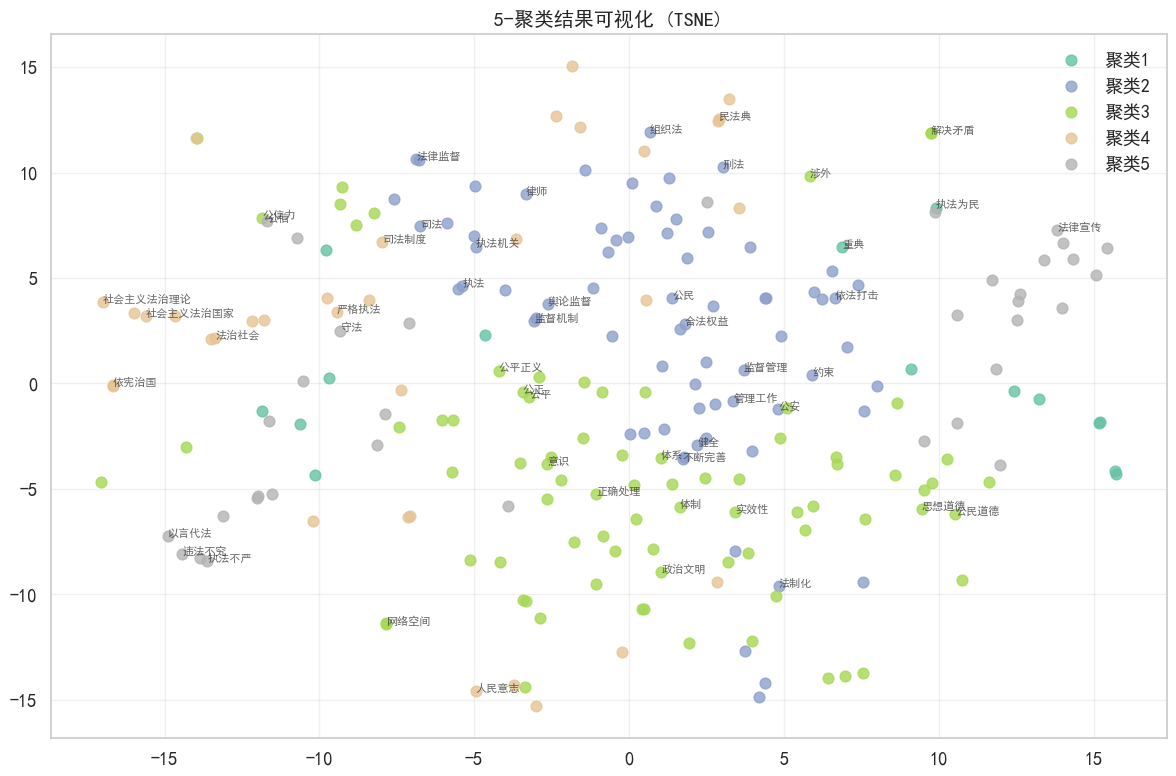

已保存聚类结果到: /home/fangshikai/law-word-vector/output/clustering_analysis/cluster_results_5d.txt
轮廓系数 (Silhouette Score): 0.033
Calinski-Harabasz 指数: 8.800

=== 分析完成 ===


In [3]:
# 2. 定义分析参数
era_files = {
    'Era1_1978-1996': 'similar_words/Era1_1978-1996_final.txt',
    'Era2_1997-2013': 'similar_words/Era2_1997-2013_final.txt',
    'Era3_2014-2024': 'similar_words/Era3_2014-2024_final.txt'
}

# 3. 运行分析
analyzer.analyze(
    era_files=era_files,
    cluster_numbers=[3, 4, 5],
    top_n=150,
    exclude_words_path="exclude_words.txt"
)

print("\n=== 分析完成 ===")